# Capstone Project : Avito Demand Prediction Challenge

`Avito (Russian based company)` created a challenge on kaggle to predict demand for an online advertisement based on its full description, its context and historical demand for similar ads in similar contexts.

The dataset for this project originates from the [avito-demand-prediction](https://www.kaggle.com/c/avito-demand-prediction) challenge. 

*I will be using subset from the dataset. train.csv & test.csv files will be imported in this project*


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# !pip install sklearn
# !pip install xgboost
# !pip install catboost
# !pip install lightgbm

# Any results you write to the current directory are saved as output.

In [2]:
import gc ### garbage collector
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from time import time

from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


In this project, I want to check how providing details of a product can affect its demand in live market. It is like a recommended system, except that the user will get a prediction of how well their product is and how well he defined it for a profit. 

### Lets have a look to our training dataset.

In [4]:
all_train_dataset = pd.read_csv("./inputs/train.csv")
all_train_dataset.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


We have to predict `deal_probability` from all inputs, which can help a user if his/her product details need more inputs or not.

*As we can see, We have different types of columns. As I will be using boosting algorithms for my project to compare those algorithms, I will  be dropping text dataset columns(which have to many different values or we can say no categorical data e.g. title, description etc) in preprocessing steps.*

--- 

Let's have a pick at test dataset too.

In [5]:
all_test_dataset = pd.read_csv("./inputs/test.csv")
all_test_dataset.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
0,6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,На ангарском,NaN,66,2017-04-18,Private,a8b57acb5ab304f9c331ac7a074219aed4d349d8aef386...,2020.0
1,65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,"Продам велосипед KAMA F200,в нормальном состо...",3000.0,4,2017-04-16,Private,NaN,NaN
2,8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,Продам новый телевизор BBK 32 диагональ смарт...,15000.0,15,2017-04-17,Private,8c361112cb049745ef2d1b0ae73594fc5c107286b0c942...,2960.0
3,8e348601fefc,5f1d5c3ce0da,Саратовская область,Саратов,Для дома и дачи,Бытовая техника,Для кухни,Вытяжки,NaN,Вытяжка Jetair 60,"Продам новую вытяжку в упаковке,с документами....",4500.0,70,2017-04-17,Private,NaN,NaN
4,8bd2fe400b89,23e2d97bfc7f,Оренбургская область,Бузулук,Личные вещи,Товары для детей и игрушки,Детские коляски,NaN,NaN,Коляска зима-лето,Продам отличную коляску. б/у 1 год. все вопрос...,4900.0,15,2017-04-15,Private,bc3cf6deef10840fc302e38eb48fa7748aa1e28d534f8f...,1002.0


Next step will be seperate out input & output fields in training dataset.

In [6]:
train_output = all_train_dataset['deal_probability'].astype('float32')
train_input = all_train_dataset.drop(['deal_probability'], axis=1)
# del all_train_dataset['deal_probability'] ###### can be used
test_input = all_test_dataset.copy()

To check how the dataset vary with different `deal_probability`. In below graph, we can check it with 1% of the dataset that its more towards low range in `deal_probability`.

In [51]:
print(np.sum(train_output > 0.5))
print(np.sum(train_output <= 0.5))

177754
1325670


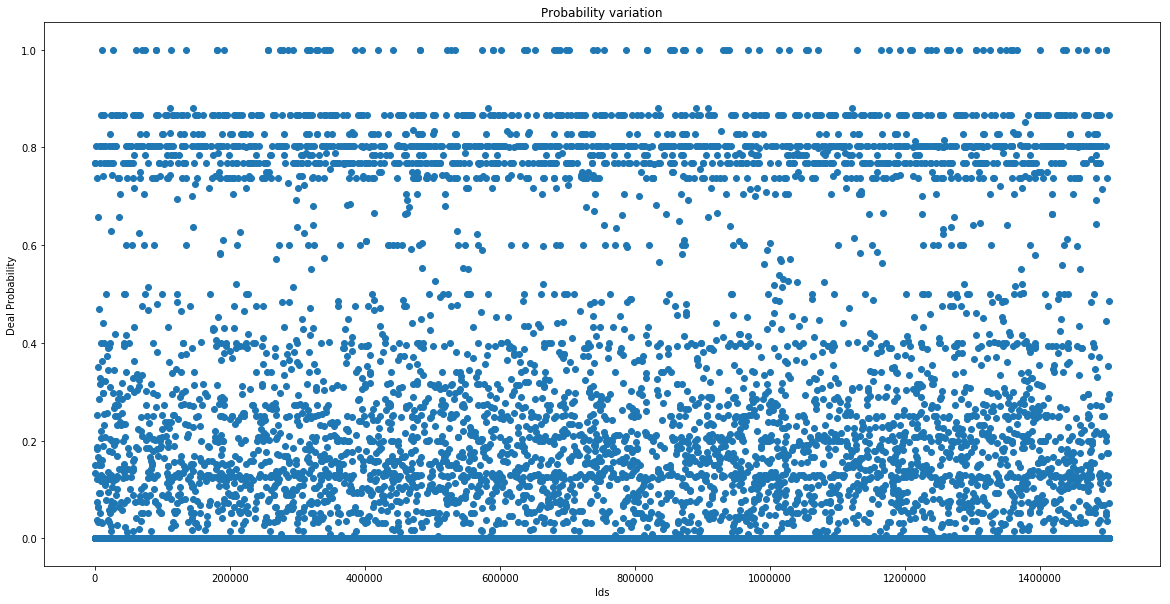

In [52]:
plt.figure(figsize=(20, 10))
dataToShow = 0.01 # percentage
indexes = np.random.randint(0, len(train_output), size=int(dataToShow * len(train_output)))
x_select = train_output.iloc[indexes]
plt.xlabel("Ids")
plt.ylabel("Deal Probability")
plt.title("Probability variation")

plt.scatter(indexes, x_select)
plt.show()

#### With multiple runs, I found differnt column names which have NaN values inside, so that I can fill those in my preprocessing step with empty strings or zeros.

Check different paramters and dtypes for columns for better understanding of data types.

In [53]:
for col in train_input.columns:
    if(col == "param_1" or col == "param_2" or col == "param_3" or col == "description" or col == "image"): # as NA exist in these columns
        print("Column Name:", col, "    #Unique Values(+1 extra):", len(np.unique(train_input[col].fillna("missing"))))
    else:
        print("Column Name:", col, "    #Unique Values:", len(np.unique(train_input[col])))

Column Name: item_id     #Unique Values: 1503424
Column Name: user_id     #Unique Values: 771769
Column Name: region     #Unique Values: 28
Column Name: city     #Unique Values: 1733
Column Name: parent_category_name     #Unique Values: 9
Column Name: category_name     #Unique Values: 47
Column Name: param_1     #Unique Values(+1 extra): 372
Column Name: price     #Unique Values: 17006
Column Name: item_seq_number     #Unique Values: 28232
Column Name: activation_date     #Unique Values: 21
Column Name: user_type     #Unique Values: 3
Column Name: image_top_1     #Unique Values: 3062
Column Name: param123     #Unique Values: 2306
Column Name: title_description     #Unique Values: 1445260
Column Name: image_exists     #Unique Values: 2


In [54]:
all_train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1387148 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null object
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
dtypes: float64(3), int

### Preprocess steps
---
1. `processData` function is used to process the NaN values in data an also to update different data types as required by different boosting algorithms.
        One e.g. I got was somthing like **ValueError: DataFrame.dtypes for data must be int, float or bool. Did not expect the data types in fields item_id, user_id, activation_date, user_type, title_description.**
        
       As These columns have text data with varying lengths, I need to drop them for my algorithm training by boosting algorithm methods.
       
---

2. `uniqueLabelsExtract` function is using LabelEncoder to find different category types for different data in train & test datasets.
[Read more about Label Encoders](https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621).

---

3. `encode2Labels` function will encode our text data to their respective category for specific columns.
    
    I will be using log for price column to adjust range of variation here. (* Using a logarithmic transformation significantly reduces the range of values caused by outliers. * )
    
    Also, for image column, I am not doing processing those files fo zip as per in dataset, But I want to make use of this column to make algorithm check if an image in description effect the outcome or not.

---

#### Note :* I didn't used [word vector](https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/) algorithms (as I am not familiar for those topics right now much.)*

In [7]:
def processData(dataset):
    print("*******Filling missing/NA values...********")
    dataset['param_1'].fillna(value='', inplace=True)
    dataset['param_2'].fillna(value='', inplace=True)
    dataset['param_3'].fillna(value='', inplace=True)
    dataset['description'].fillna(value='', inplace=True)
    dataset['image_top_1'].fillna(value=0, inplace=True)
    dataset['price'].fillna(value=1, inplace=True)

    print("*******Data type adjustments...********")
    # https://stackoverflow.com/questions/21018654/strings-in-a-dataframe-but-dtype-is-object
    # https://stackoverflow.com/questions/33957720/how-to-convert-column-with-dtype-as-object-to-string-in-pandas-dataframe
    # dataset['param_1'] = dataset['param_1'].astype(str)
    # dataset['param_2'] = dataset['param_2'].astype(str)
    # dataset['param_3'] = dataset['param_3'].astype(str)
    # dataset['price'] = dataset['price'].astype('float32')
    # dataset['item_seq_number'] = dataset['item_seq_number'].astype('uint32')
    data_type = {
        'param_1': str, 
        'param_2': str, 
        'param_3': str, 
        'price': 'float64', 
        'item_seq_number': 'uint32',
        'image_top_1': 'uint32',
    }
    dataset = dataset.astype(data_type)
    dataset['param123'] = (dataset['param_1']+'_'+dataset['param_2']+'_'+dataset['param_3']).astype(str)
    dataset['title_description']= (dataset['title']+' '+dataset['description']).astype(str)
    dataset['image_exists'] = dataset['image'].isnull().astype(int)
    
    del dataset['param_2'], dataset['param_3'], dataset['description'], dataset['title'], dataset['image']
    gc.collect()
    
    return dataset

def uniqueLabelsExtract(train_data, test_data):
    DF = pd.concat([train_data, test_data], axis = 0)
    print("*******Starting Label Encoding process...********")
    # https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621
    le_region = LabelEncoder()
    le_region.fit(DF.region)
    
    le_city = LabelEncoder()
    le_city.fit(DF.city)
    
    le_user_type = LabelEncoder()
    le_user_type.fit(DF.user_type)
    
    le_category_name = LabelEncoder()
    le_category_name.fit(DF.category_name)
    
    le_parent_category_name = LabelEncoder()
    le_parent_category_name.fit(DF.parent_category_name)
    
    le_param_1 = LabelEncoder()
    le_param_1.fit(DF.param_1)
    
    le_param123 = LabelEncoder()
    le_param123.fit(DF.param123)
    
    print("Finished Label Encoding process.")
    del DF 
    gc.collect()
    
    return le_region, le_city, le_user_type, le_category_name, le_parent_category_name, le_param_1, le_param123

def encode2Labels(dataset):
    print("*******Encoding dataset via LabelEncoder...*********")
    dataset['region'] = le_region.transform(dataset['region'])
    dataset['city'] = le_city.transform(dataset['city'])
    dataset['user_type'] = le_user_type.transform(dataset['user_type'])
    dataset['category_name'] = le_category_name.transform(dataset['category_name'])
    dataset['parent_category_name'] = le_parent_category_name.transform(dataset['parent_category_name'])
    dataset['param_1'] = le_param_1.transform(dataset['param_1'])
    dataset['param123'] = le_param123.transform(dataset['param123'])
    dataset['price'] = np.log1p(dataset['price'])
    dataset['item_seq_number'] = np.log(dataset['item_seq_number'])
    print("*******Finished Encoding dataset.*********")
    return dataset

def rmse(y, y_pred):
    Rsum = np.sum((y - y_pred)**2)
    n = y.shape[0]
    RMSE = np.sqrt(Rsum/n)
    return RMSE 

Using preprocessing step on our available datasets.

In [8]:
train_output = all_train_dataset['deal_probability'].astype('float32')
train_input = all_train_dataset.drop(['deal_probability'], axis=1)
# del all_train_dataset['deal_probability'] ###### can be used
test_input = all_test_dataset.copy()

print("Training data processing...")
train_input = processData(train_input)
print("Testing data processing...")
test_input = processData(test_input)
print("Label Encoder generator...")
le_region, le_city, le_user_type, le_category_name, le_parent_category_name, le_param_1, le_param123 = \
                                    uniqueLabelsExtract(train_input, test_input)

train_input = encode2Labels(train_input)
test_input = encode2Labels(test_input)

print("Training-Validation Split of dataset")
train_x, valid_x, train_y, valid_y = train_test_split(train_input, train_output, train_size=0.85, random_state=40)
print(train_x.shape, valid_x.shape)
print(train_y.shape, valid_y.shape)


Training data processing...
*******Filling missing/NA values...********
*******Data type adjustments...********
Testing data processing...
*******Filling missing/NA values...********
*******Data type adjustments...********
Label Encoder generator...
*******Starting Label Encoding process...********
Finished Label Encoding process.
*******Encoding dataset via LabelEncoder...*********
*******Finished Encoding dataset.*********
*******Encoding dataset via LabelEncoder...*********
*******Finished Encoding dataset.*********
Training-Validation Split of dataset


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(1277910, 15) (225514, 15)
(1277910,) (225514,)


** Splitting our dataset in train:validation bins in ratio of ~~0.75:0.25~~ 0.85:0.15 .** As I go through my work, I update my ratio in final run.

In [56]:
train_x.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,price,item_seq_number,activation_date,user_type,image_top_1,param123,title_description,image_exists
147280,9ddc73b185a7,ffe138e90bf1,23,1558,0,41,32,9.210440,1.945910,2017-03-24,1,0,35,iPhone 5s Продам iphone 5s gold 16g в отличном...,1
1025654,79a7797cd3e4,8777b00c3c3f,7,1669,8,31,0,6.216606,2.708050,2017-03-19,1,2228,34,Набор для чистки охотничьего ружья 12 калибра,0
449102,c4f37c421b67,6b0ae05314d7,26,1532,4,29,126,7.003974,5.236442,2017-03-21,0,545,318,Осенняя куртка Осенняя курточка в хорошем сост...,0
739946,5292b49f8503,2392e397706b,26,1650,2,4,106,9.296610,9.920787,2017-03-18,0,1988,209,Узкая стиральная машина Bosch Serie 2 WLG2406M...,0
762521,850b7f103e60,eeb8e00558c5,9,1602,4,42,134,5.707110,3.091042,2017-03-19,1,1004,406,"Коляска для кукол для игры в куклы,в хорошем с...",0


In [57]:
# from xgboost import XGBRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import RandomForestRegressor
# from catboost import CatBoostRegressor
# from lightgbm import LGBMRegressor

# # # train_x, valid_x, train_y, valid_y 
# # input_train = train_x.copy()
# # input_valid = valid_x.copy()
# # output_train = train_y.copy()
# # output_valid = valid_y.copy()


# ValueError: DataFrame.dtypes for data must be int, float or bool.
#                 Did not expect the data types in fields item_id, user_id, activation_date, user_type, title_description


# train_x.describe()


# col_to_delete_for_fit = ['item_id', 'user_id', 'activation_date', 'title_description']
# input_train = train_x.drop(col_to_delete_for_fit, axis=1)
# # for col in input_train.columns:
# #     print(col, np.sum(~np.isfinite(input_train[col])))

# input_train[~np.isfinite(input_train['price'])]['price']

## Training step for evaluating algorithms

1. `train_predict` function will be used to save different algorithms *train time*, *validation time*, *training error* and validation error*. 

*I took help from finding_donors project in ML Nanodegree for drawing charts like this.*

In [59]:
from time import time

def train_predict(learner, sample_size, col_to_delete_for_fit, input_train_f, output_train, input_valid_f, output_valid): 
    results = {}
    
    input_train = input_train_f.drop(col_to_delete_for_fit, axis=1)
    input_valid = input_valid_f.drop(col_to_delete_for_fit, axis=1)
    
    start = time() # Get start time
    learner = learner.fit(X=input_train.iloc[:sample_size], y=output_train.iloc[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    start = time() # Get start time
    predictions_train = learner.predict(input_train.iloc[:sample_size])
    predictions_valid = learner.predict(input_valid)
    end = time() # Get end time    
    results['pred_time'] = end - start
    
    results['rmse_train'] = rmse(output_train.iloc[:sample_size], predictions_train)
    results['rmse_valid'] = rmse(output_valid, predictions_valid)

    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    print('results:', results)
    return results

In [60]:
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
# XGBRegressor, CatBoostRegressor, LGBMRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
reg_A = XGBRegressor(random_state=40)
reg_B = CatBoostRegressor(random_state=40, verbose=0)
reg_C = LGBMRegressor(random_state=40)
reg_D = GradientBoostingRegressor(random_state=40)
reg_E = AdaBoostRegressor(random_state=40)
reg_F = RandomForestRegressor(random_state=40)

samples_100 = int(len(train_x)*100/100)
samples_10 = int(len(train_x)*10/100)
samples_1 = int(len(train_x)*1/100)

col_to_delete_for_fit = ['item_id', 'user_id', 'activation_date', 'title_description']

results = {}
# for reg in [reg_A]:
for reg in [reg_A, reg_B, reg_C, reg_D, reg_E, reg_F]:
    reg_name = reg.__class__.__name__
    results[reg_name] = {}
    # for i, samples in enumerate([samples_100]):
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[reg_name][i] = train_predict(reg, samples, col_to_delete_for_fit, train_x, train_y, valid_x, valid_y)


XGBRegressor trained on 12779 samples.
results: {'train_time': 0.6637618541717529, 'pred_time': 0.5413925647735596, 'rmse_train': 0.23209915692390154, 'rmse_valid': 0.23916004167653696}
XGBRegressor trained on 127791 samples.
results: {'train_time': 6.993561267852783, 'pred_time': 0.7660367488861084, 'rmse_train': 0.23645782093009296, 'rmse_valid': 0.23706183817697954}
XGBRegressor trained on 1277910 samples.
results: {'train_time': 105.50648999214172, 'pred_time': 3.234600305557251, 'rmse_train': 0.23682830033249136, 'rmse_valid': 0.2369794766776338}
CatBoostRegressor trained on 12779 samples.
results: {'train_time': 23.488276720046997, 'pred_time': 0.21661067008972168, 'rmse_train': 0.22768204023830454, 'rmse_valid': 0.2373926043969714}
CatBoostRegressor trained on 127791 samples.
results: {'train_time': 27.063827991485596, 'pred_time': 0.32987403869628906, 'rmse_train': 0.23018641305666454, 'rmse_valid': 0.23277957368014063}
CatBoostRegressor trained on 1277910 samples.
results: {'t

In [61]:
def evaluate(results):
    import matplotlib.pyplot as pl
    # Create figure
    fig, ax = pl.subplots(2, 3, figsize = (15,8))
    # Constants
    bar_width = 0.1
    colors = ['#A00000','#00A0A0','#12A000', '#A123A2', '#98ABAB', '#652132']

    # Super loop to plot data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'rmse_train', 'pred_time', 'rmse_valid']):
            for i in np.arange(3):
                # Creative plot code
                ax[j//2, j%2].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//2, j%2].set_xticks([0.45, 1.45, 2.45])
                ax[j//2, j%2].set_xticklabels(["1%", "10%", "100%"])
                ax[j//2, j%2].set_xlabel("Training Set Size")
                ax[j//2, j%2].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("RMSE Error")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("RMSE Error")
    
    # Add titles
    ax[0, 0].set_title("Model Training Time")
    ax[0, 1].set_title("RMSE Score on Training Subset")
    ax[1, 0].set_title("Model Predicting Time")
    ax[1, 1].set_title("RMSE Score on Validating Set")
    
    # Set y-limits for score panels
    # ax[0, 1].set_ylim((0, 1))
    # ax[1, 1].set_ylim((0, 1))

    # Set additional plots invisibles
    ax[0, 2].set_visible(False)
    ax[1, 2].axis('off')

    # Create legend
    for i, learner in enumerate(results.keys()):
        pl.bar(0, 0, color=colors[i], label=learner)
    pl.legend()
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Six Supervised Learning Models", fontsize = 16, y = 1.10)
    pl.tight_layout()
    pl.show()

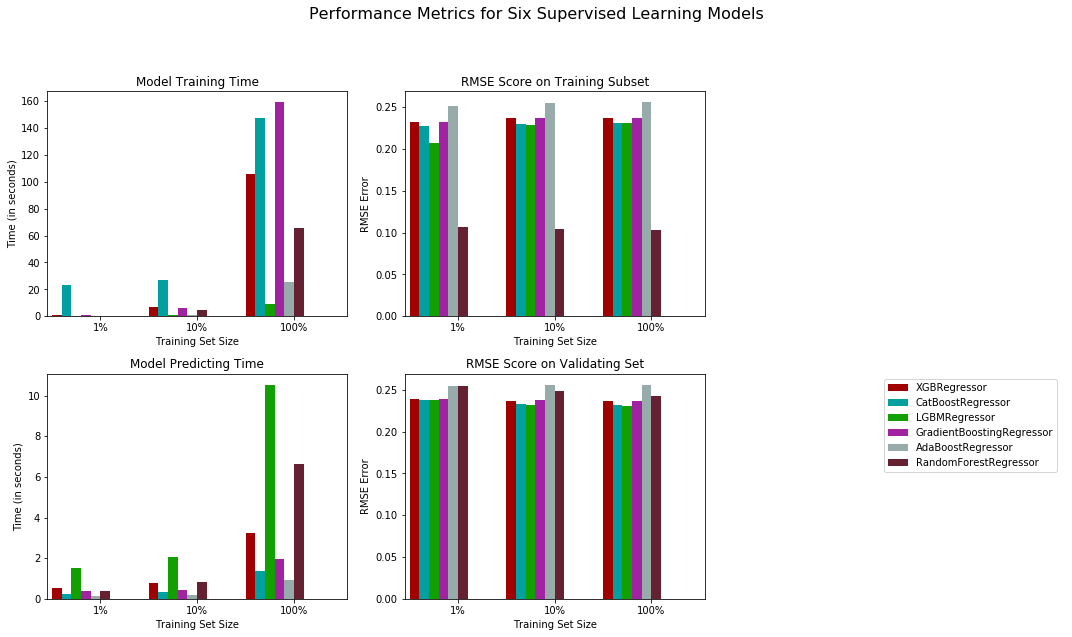

In [62]:
evaluate(results)

As We can check:  XGBRegressor, CatBootRegressor, LGBMRegressor outperforms GradientBoostingRegressor, AdaBoostRegressor.
Let us view the charts in more details:
    - RandomForestRegressor have RMSE error of 0.10 in training data but have 0.24 in validation data,meaning its overfit the data in training set.
    - AdaBoost speed is fine, but as per RMSE error, it lags behind other algorithms.
    - GradientBoostingRegressor is fine also but I want to explore first 3 in more details, i didn't use it further :)
    - Best one in all for now is LGBMRegressor & CatBoostRegressor as similar range of errors help me build my intuition.

In [ ]:
for name, samples in results.items():
    for i, details in samples.items():
        # print(name, i, details['rmse_train'], details['rmse_valid'])
        if i == 2:
            print(name, "on 100% samples => ", details['rmse_train'], details['rmse_valid'])

#### Training step with hyperparamters

1. `useStaticParamters` is used to set static paramters for (algorithms I deicded above ) GridSearchCV.

2. `useDynamicParamters` is used to set dynamic paramters generation for (algorithms I deicded above ) GridSearchCV.

3. `modelEvaluator` is training each model/learner with GridSearchCV for finding better paramters based on **RMSE metric**

In [14]:
def useStaticParamters(model_name):
    parameters = {}
    if(model_name == 'LGBMRegressor'):
        parameters = {'n_estimators': [150, 300], 'num_leaves': [50, 80], 'learning_rate': [0.01, 0.1, 0.5]}
    elif(model_name == 'CatBoostRegressor'):
        parameters = {'n_estimators': [150, 300], 'learning_rate': [0.01, 0.05, 0.1]}
    elif(model_name == 'XGBRegressor'):
        parameters = {'n_estimators': [150, 300], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3,5,7]}
    else:
        parameters = {'learning_rate': [0.01, 0.05, 0.1]}
    return parameters
def useDynamicParamters(model_name):
    parameters = {}
    if(model_name == 'LGBMRegressor'):
        parameters = {
            'n_estimators': np.random.randint(100, 500, 2), 
            'num_leaves': np.random.randint(50, 100, 2), 
            'learning_rate': np.random.rand(1, 3)[0]
        }
    elif(model_name == 'CatBoostRegressor'):
        parameters = {
            'n_estimators': np.random.randint(100, 500, 2), 
            'learning_rate': np.random.rand(1, 3)[0]
        }
    elif(model_name == 'XGBRegressor'):
        parameters = {
            'n_estimators': np.random.randint(100, 500, 2), 
            'learning_rate': np.random.rand(1, 3)[0],
            'max_depth': np.random.randint(3, 10, 3)
        }
    else:
        print("**********Model Name issue*************")
        parameters = { 'learning_rate': np.random.rand(1, 3)[0] }
    return parameters
def modelEvaluator(learner, col_to_delete,input_train_temp,output_train, input_valid_temp,output_valid, scorer,paramRand=False): 
    results = {}
    
    input_train = input_train_temp.drop(col_to_delete, axis=1)
    input_valid = input_valid_temp.drop(col_to_delete, axis=1)
    if paramRand:
        parameters = useDynamicParamters(learner.__class__.__name__)
    else:
        parameters = useStaticParamters(learner.__class__.__name__)
    start = time() # Get start time
    grid_obj = GridSearchCV(estimator=learner, param_grid=parameters, scoring=scorer, verbose=3)
    grid_fit = grid_obj.fit(input_train, output_train)
    best_reg = grid_fit.best_estimator_
    results['best_model'] = best_reg
    best_reg = best_reg.fit(input_train, output_train)
    results['best_model_fitted'] = best_reg
    end = time() # Get end time
    # TODO: Calculate the training time
    results['train_time'] = end - start
    
    start = time() # Get start time
    predictions_train = best_reg.predict(input_train)
    predictions_valid = best_reg.predict(input_valid)
    end = time() # Get end time    
    results['pred_time'] = end - start
    
    results['rmse_train'] = rmse(output_train, predictions_train)
    results['rmse_valid'] = rmse(output_valid, predictions_valid)

    print("{} trained Successfully.".format(learner.__class__.__name__))
    print('results:', results)
    return results

In [12]:
# from sklearn.grid_search import GridSearchCV
# from sklearn.metrics import make_scorer
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

reg_A = XGBRegressor(random_state=40)
reg_B = CatBoostRegressor(random_state=40, verbose=0)
reg_C = LGBMRegressor(random_state=40)

col_to_delete_for_fit = ['item_id', 'user_id', 'activation_date', 'title_description']
scorer = make_scorer(rmse, greater_is_better=False)

grid_results_static = {}
for reg in [reg_A, reg_B, reg_C]:
# for reg in [reg_C]:
    reg_name = reg.__class__.__name__
    grid_results_static[reg_name] = {}
    grid_results_static[reg_name] = modelEvaluator(reg, col_to_delete_for_fit, train_x, train_y, valid_x, valid_y, scorer, False)
   

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] learning_rate=0.01, max_depth=3, n_estimators=150 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=150, score=-0.25735089726677357, total= 1.5min
[CV] learning_rate=0.01, max_depth=3, n_estimators=150 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=3, n_estimators=150, score=-0.25716486013574125, total= 1.5min
[CV] learning_rate=0.01, max_depth=3, n_estimators=150 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=3, n_estimators=150, score=-0.2576280103242679, total= 1.5min
[CV] learning_rate=0.01, max_depth=3, n_estimators=300 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=300, score=-0.2421071144756904, total= 3.0min
[CV] learning_rate=0.01, max_depth=3, n_estimators=300 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=300, score=-0.24176284404919057, total= 3.0min
[CV] learning_rate=0.01, max_depth=3, n_estimators=300 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=300, score=-0.2423211091380929, total= 3.0min
[CV] learning_rate=0.01, max_depth=5, n_estimators=150 ...............
[CV]  learning_rate=0.01, max_depth=5, n_estimators=150, score=-0.25384377953205367, total= 2.3min
[CV] learning_rate=0.01, max_depth=5, n_estimators=150 ...............
[CV]  learning_rate=0.01, max_depth=5, n_estimators=150, score=-0.25364672847587927, total= 2.4min
[CV] learning_rate=0.01, max_depth=5, n_estimators=150

[CV]  learning_rate=0.1, max_depth=7, n_estimators=300, score=-0.22724743390795435, total= 6.0min
[CV] learning_rate=0.1, max_depth=7, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=7, n_estimators=300, score=-0.22679439678556265, total= 6.0min
[CV] learning_rate=0.1, max_depth=7, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=7, n_estimators=300, score=-0.22754485698902435, total= 6.1min


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 230.5min finished


XGBRegressor trained Successfully.
results: {'best_model': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=40,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1), 'best_model_fitted': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=40,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1), 'train_time': 15101.925687551498, 'pred_time': 33.254379749298096, 'rmse_train': 0.22380145181210112, 'rmse_valid': 0.22688456523621184}
Fitting 3 folds

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.4s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=150, score=-0.24393209856371414, total=  17.4s
[CV] learning_rate=0.01, n_estimators=150 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   36.6s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=150, score=-0.2445083030560304, total=  16.7s
[CV] learning_rate=0.01, n_estimators=300 ............................
[CV]  learning_rate=0.01, n_estimators=300, score=-0.2393207399579287, total=  33.6s
[CV] learning_rate=0.01, n_estimators=300 ............................
[CV]  learning_rate=0.01, n_estimators=300, score=-0.23896703932151872, total=  31.4s
[CV] learning_rate=0.01, n_estimators=300 ............................
[CV]  learning_rate=0.01, n_estimators=300, score=-0.2394940832539104, total=  32.5s
[CV] learning_rate=0.05, n_estimators=150 ............................
[CV]  learning_rate=0.05, n_estimators=150, score=-0.2358845975394569, total=  16.8s
[CV] learning_rate=0.05, n_estimators=150 ............................
[CV]  learning_rate=0.05, n_estimators=150, score=-0.235609805839734, total=  18.9s
[CV] learning_rate=0.05, n_estimators=150 ............................
[CV]  learning_rate=0.05, n_estimators=150, score=-0.23604777499

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  7.8min finished


CatBoostRegressor trained Successfully.
results: {'best_model': <catboost.core.CatBoostRegressor object at 0x000001D92CCAA978>, 'best_model_fitted': <catboost.core.CatBoostRegressor object at 0x000001D92CCAA978>, 'train_time': 562.0310060977936, 'pred_time': 1.3275277614593506, 'rmse_train': 0.2314429399431053, 'rmse_valid': 0.23164672658468144}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] learning_rate=0.01, n_estimators=150, num_leaves=50 .............
[CV]  learning_rate=0.01, n_estimators=150, num_leaves=50, score=-0.23688007676234996, total=  16.0s
[CV] learning_rate=0.01, n_estimators=150, num_leaves=50 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.9s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=150, num_leaves=50, score=-0.23653524840983695, total=  15.6s
[CV] learning_rate=0.01, n_estimators=150, num_leaves=50 .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.5s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=150, num_leaves=50, score=-0.23701728474739808, total=  15.3s
[CV] learning_rate=0.01, n_estimators=150, num_leaves=80 .............
[CV]  learning_rate=0.01, n_estimators=150, num_leaves=80, score=-0.23553544656022465, total=  18.3s
[CV] learning_rate=0.01, n_estimators=150, num_leaves=80 .............
[CV]  learning_rate=0.01, n_estimators=150, num_leaves=80, score=-0.23505896834263573, total=  19.9s
[CV] learning_rate=0.01, n_estimators=150, num_leaves=80 .............
[CV]  learning_rate=0.01, n_estimators=150, num_leaves=80, score=-0.2356176657308915, total=  20.0s
[CV] learning_rate=0.01, n_estimators=300, num_leaves=50 .............
[CV]  learning_rate=0.01, n_estimators=300, num_leaves=50, score=-0.233035067165405, total=  31.4s
[CV] learning_rate=0.01, n_estimators=300, num_leaves=50 .............
[CV]  learning_rate=0.01, n_estimators=300, num_leaves=50, score=-0.23272515341924588, total=  31.9s
[CV] learning_rate=0.01, n_estimators=300,

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 18.7min finished


LGBMRegressor trained Successfully.
results: {'best_model': LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=300, n_jobs=-1, num_leaves=80, objective=None,
       random_state=40, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0), 'best_model_fitted': LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=300, n_jobs=-1, num_leaves=80, objective=None,
       random_state=40, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0), 'train_time': 1163.4803159236908, 'pred_time': 31.28820276260376, 'rmse_train': 0.224

In [13]:
grid_results_static

{'XGBRegressor': {'best_model': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
         max_depth=7, min_child_weight=1, missing=None, n_estimators=300,
         n_jobs=1, nthread=None, objective='reg:linear', random_state=40,
         reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
         silent=True, subsample=1),
  'best_model_fitted': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
         max_depth=7, min_child_weight=1, missing=None, n_estimators=300,
         n_jobs=1, nthread=None, objective='reg:linear', random_state=40,
         reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
         silent=True, subsample=1),
  'train_time': 15101.925687551498,
  'pred_time': 33.254379749298096,
  'rmse_train': 0.22380145181210112,
  'rmse_valid': 0.22688456523621184},
 'CatBoostR

In [15]:
reg_A = XGBRegressor(random_state=40)
reg_B = CatBoostRegressor(random_state=40, verbose=0)
reg_C = LGBMRegressor(random_state=40)

col_to_delete_for_fit = ['item_id', 'user_id', 'activation_date', 'title_description']
scorer = make_scorer(rmse, greater_is_better=False)

grid_results_dynamic = {}
for reg in [reg_A, reg_B, reg_C]:
# for reg in [reg_C]:
    reg_name = reg.__class__.__name__
    grid_results_dynamic[reg_name] = {}
    grid_results_dynamic[reg_name] = modelEvaluator(reg, col_to_delete_for_fit, train_x, train_y, valid_x, valid_y, scorer, True)
    

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] learning_rate=0.3962431373341353, max_depth=9, n_estimators=204 .
[CV]  learning_rate=0.3962431373341353, max_depth=9, n_estimators=204, score=-0.22903112368218753, total= 5.4min
[CV] learning_rate=0.3962431373341353, max_depth=9, n_estimators=204 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.7min remaining:    0.0s


[CV]  learning_rate=0.3962431373341353, max_depth=9, n_estimators=204, score=-0.22869074687946891, total= 5.4min
[CV] learning_rate=0.3962431373341353, max_depth=9, n_estimators=204 .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.4min remaining:    0.0s


[CV]  learning_rate=0.3962431373341353, max_depth=9, n_estimators=204, score=-0.229423682936929, total= 5.7min
[CV] learning_rate=0.3962431373341353, max_depth=9, n_estimators=412 .
[CV]  learning_rate=0.3962431373341353, max_depth=9, n_estimators=412, score=-0.23118346301399567, total=10.7min
[CV] learning_rate=0.3962431373341353, max_depth=9, n_estimators=412 .
[CV]  learning_rate=0.3962431373341353, max_depth=9, n_estimators=412, score=-0.2311118935081838, total=11.4min
[CV] learning_rate=0.3962431373341353, max_depth=9, n_estimators=412 .
[CV]  learning_rate=0.3962431373341353, max_depth=9, n_estimators=412, score=-0.23175315592673906, total=11.5min
[CV] learning_rate=0.3962431373341353, max_depth=6, n_estimators=204 .
[CV]  learning_rate=0.3962431373341353, max_depth=6, n_estimators=204, score=-0.22721984047469412, total= 3.7min
[CV] learning_rate=0.3962431373341353, max_depth=6, n_estimators=204 .
[CV]  learning_rate=0.3962431373341353, max_depth=6, n_estimators=204, score=-0.226

[CV]  learning_rate=0.9497976952358125, max_depth=6, n_estimators=412, score=-0.23419871579769552, total= 8.0min
[CV] learning_rate=0.9497976952358125, max_depth=8, n_estimators=204 .
[CV]  learning_rate=0.9497976952358125, max_depth=8, n_estimators=204, score=-0.23953972364502416, total= 5.2min
[CV] learning_rate=0.9497976952358125, max_depth=8, n_estimators=204 .
[CV]  learning_rate=0.9497976952358125, max_depth=8, n_estimators=204, score=-0.23938345978860556, total= 5.1min
[CV] learning_rate=0.9497976952358125, max_depth=8, n_estimators=204 .
[CV]  learning_rate=0.9497976952358125, max_depth=8, n_estimators=204, score=-0.2398943807570752, total= 5.1min
[CV] learning_rate=0.9497976952358125, max_depth=8, n_estimators=412 .
[CV]  learning_rate=0.9497976952358125, max_depth=8, n_estimators=412, score=-0.24758496022149154, total=10.0min
[CV] learning_rate=0.9497976952358125, max_depth=8, n_estimators=412 .
[CV]  learning_rate=0.9497976952358125, max_depth=8, n_estimators=412, score=-0.2

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 949.1min finished


XGBRegressor trained Successfully.
results: {'best_model': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3962431373341353,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=412, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=40, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1), 'best_model_fitted': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3962431373341353,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=412, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=40, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1), 'train_time': 59200.62247633934, 'pred_time': 86.07266235351562, 'rmse_train': 0.21839573462314113, 'rmse_valid': 0.225760

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.3s remaining:    0.0s


[CV]  learning_rate=0.6617097822457528, n_estimators=151, score=-0.22970969595479585, total=  33.7s
[CV] learning_rate=0.6617097822457528, n_estimators=151 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.6617097822457528, n_estimators=151, score=-0.23029198250272598, total=  33.5s
[CV] learning_rate=0.6617097822457528, n_estimators=296 ..............
[CV]  learning_rate=0.6617097822457528, n_estimators=296, score=-0.22924551347229952, total=  54.3s
[CV] learning_rate=0.6617097822457528, n_estimators=296 ..............
[CV]  learning_rate=0.6617097822457528, n_estimators=296, score=-0.22905912511446058, total=  55.0s
[CV] learning_rate=0.6617097822457528, n_estimators=296 ..............
[CV]  learning_rate=0.6617097822457528, n_estimators=296, score=-0.22955123473655, total=  57.1s
[CV] learning_rate=0.3239134232791766, n_estimators=151 ..............
[CV]  learning_rate=0.3239134232791766, n_estimators=151, score=-0.23082883846812507, total=  33.2s
[CV] learning_rate=0.3239134232791766, n_estimators=151 ..............
[CV]  learning_rate=0.3239134232791766, n_estimators=151, score=-0.2303445749743093, total=  30.0s
[CV] learning_rate=0.3239134232791766, n_estimato

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 13.9min finished


CatBoostRegressor trained Successfully.
results: {'best_model': <catboost.core.CatBoostRegressor object at 0x000001D937F501D0>, 'best_model_fitted': <catboost.core.CatBoostRegressor object at 0x000001D937F501D0>, 'train_time': 991.1595320701599, 'pred_time': 3.1253607273101807, 'rmse_train': 0.22728636037808625, 'rmse_valid': 0.22881919648520477}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] learning_rate=0.6246480671655634, n_estimators=484, num_leaves=81 
[CV]  learning_rate=0.6246480671655634, n_estimators=484, num_leaves=81, score=-0.23523255322561057, total= 1.0min
[CV] learning_rate=0.6246480671655634, n_estimators=484, num_leaves=81 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s


[CV]  learning_rate=0.6246480671655634, n_estimators=484, num_leaves=81, score=-0.23494883580701997, total=  24.6s
[CV] learning_rate=0.6246480671655634, n_estimators=484, num_leaves=81 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.0min remaining:    0.0s


[CV]  learning_rate=0.6246480671655634, n_estimators=484, num_leaves=81, score=-0.23587320050052332, total=  24.0s
[CV] learning_rate=0.6246480671655634, n_estimators=484, num_leaves=64 
[CV]  learning_rate=0.6246480671655634, n_estimators=484, num_leaves=64, score=-0.23397292531787198, total=  23.0s
[CV] learning_rate=0.6246480671655634, n_estimators=484, num_leaves=64 
[CV]  learning_rate=0.6246480671655634, n_estimators=484, num_leaves=64, score=-0.23332553783523186, total=  22.9s
[CV] learning_rate=0.6246480671655634, n_estimators=484, num_leaves=64 
[CV]  learning_rate=0.6246480671655634, n_estimators=484, num_leaves=64, score=-0.2341961014771064, total=  23.3s
[CV] learning_rate=0.6246480671655634, n_estimators=349, num_leaves=81 
[CV]  learning_rate=0.6246480671655634, n_estimators=349, num_leaves=81, score=-0.23335149200477417, total=  18.2s
[CV] learning_rate=0.6246480671655634, n_estimators=349, num_leaves=81 
[CV]  learning_rate=0.6246480671655634, n_estimators=349, num_leav

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 25.8min finished


LGBMRegressor trained Successfully.
results: {'best_model': LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.41919691265077863,
       max_depth=-1, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=349, n_jobs=-1, num_leaves=64,
       objective=None, random_state=40, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0), 'best_model_fitted': LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.41919691265077863,
       max_depth=-1, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=349, n_jobs=-1, num_leaves=64,
       objective=None, random_state=40, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0), 'train_time': 1580.4426953792572, 'pred

In [16]:
grid_results_dynamic

{'XGBRegressor': {'best_model': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=1, gamma=0, learning_rate=0.3962431373341353,
         max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
         n_estimators=412, n_jobs=1, nthread=None, objective='reg:linear',
         random_state=40, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
         seed=None, silent=True, subsample=1),
  'best_model_fitted': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=1, gamma=0, learning_rate=0.3962431373341353,
         max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
         n_estimators=412, n_jobs=1, nthread=None, objective='reg:linear',
         random_state=40, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
         seed=None, silent=True, subsample=1),
  'train_time': 59200.62247633934,
  'pred_time': 86.07266235351562,
  'rmse_train': 0.21839573462314113,
  'rmse_valid': 0.225

Evaluating best model depending on Validation error. I manullay do tried them for different values.

In [19]:
lowest_error = grid_results_dynamic['XGBRegressor']['rmse_valid']
best_model = grid_results_dynamic['XGBRegressor']['best_model_fitted']

for name, details in grid_results_dynamic.items():
    if(details['rmse_valid'] < lowest_error):
        lowest_error = grid_results_dynamic[name]['rmse_valid']
        best_model = grid_results_dynamic[name]['best_model_fitted']

for name, details in grid_results_static.items():
    if(details['rmse_valid'] < lowest_error):
        lowest_error = grid_results_dynamic[name]['rmse_valid']
        best_model = grid_results_dynamic[name]['best_model_fitted']


In [21]:
best_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3962431373341353,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=412, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=40, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

### Generating csv file for late submitting @ kaggle

In [24]:
submission = pd.read_csv("./inputs/sample_submission.csv")
# test_input = encode2Labels(test_input)
col_to_delete_for_fit = ['item_id', 'user_id', 'activation_date', 'title_description']
tt = test_input.drop(col_to_delete_for_fit, axis=1)
# submission['deal_probability'] = submission['deal_probability'].apply(lambda x: np.abs(x) )

submission['deal_probability'] = best_model.predict(tt)
submission['deal_probability'] = submission['deal_probability'].apply(lambda x: np.abs(x) )
print("submitting dynamic paramters csv")
submission.to_csv("submissionMine.csv", index=False)

submitting dynamic paramters csv


Submission @Kaggle of csv file.

![alt text][logo]

[logo]: ./submissions.png "Logo Title Text 2"


As I can compare, XGB outperform other by small margin. But I need to do more traininig for much better results. Top score in this competition is at 0.21 which I am not even close. I will be reading more about word embedding so that i can use them in my training set and not to drop them.



In [65]:
gc.collect()

0